#  Прогнозирование заказов такси

Входные данные: исторические данные о заказах такси в аэропортах

Цель работы: <br>
Построить модель для прогнозирования количества заказов на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия-и-catboost" data-toc-modified-id="Линейная-регрессия-и-catboost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия и catboost</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

In [1]:
import os
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

from datetime import datetime as dt

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

plt.style.use('seaborn')

## Подготовка

In [2]:
if os.path.exists('taxi.csv'):
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
elif os.path.exists('/datasets/taxi.csv'):
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
else:
    print("Проверьте правильность пути к датасету autos.csv")

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выполнить ресемлирование по одному часу, сложив количество заказов.

In [4]:
data = data.resample('1H').sum()

In [5]:
print('Данные монотонны' if data.index.is_monotonic else 'Данные не монотонны')

Данные монотонны


## Анализ

Для начала проведем базовый анализ данных:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Тип количества заказов - `int`, проверим данные на наличие пропусков:

In [7]:
data.isna().sum().sum()

0

Пропусков нет, данные монотонны, поэтому логично предположить, что дубликатов нет.

Рассмотрим распределение количества продаж:

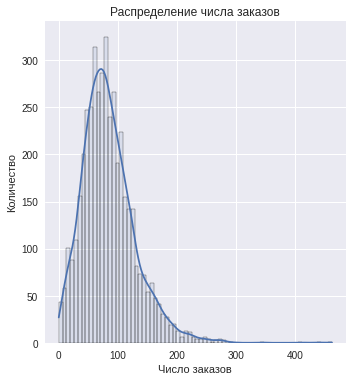

In [8]:
sns.displot(data, kind='hist', legend=False, kde=True, alpha=.1)
plt.xlabel('Число заказов')
plt.ylabel('Количество')
plt.title('Распределение числа заказов')
plt.show()

Распределение имеет сдвинутый влево нормальный характер с хвостом справа.

Рассмотрим тренд и сезонность временного ряда:

In [9]:
decomposed = seasonal_decompose(data.resample('1D').sum())

Рассмотрим сезонную составляющую.

Будем рассматривать один месяц для выявления сезонности. 

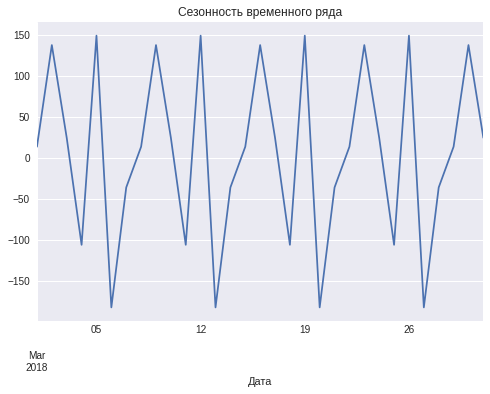

In [10]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot()
plt.title('Сезонность временного ряда')
plt.xlabel('Дата')
plt.show()

Из графика видно, что наблюдается сезонность в **6 дней**.

Рассмотрим тренд временного ряда.

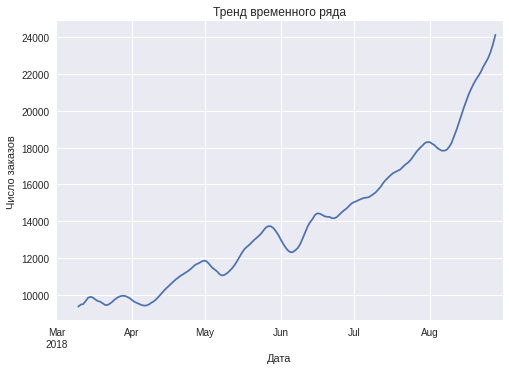

In [11]:
decomposed.trend.rolling(7).sum().plot()
plt.title('Тренд временного ряда')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.show()

Видно, что число заказов имеют положительный тренд.

Также поизведем анализ остатков:

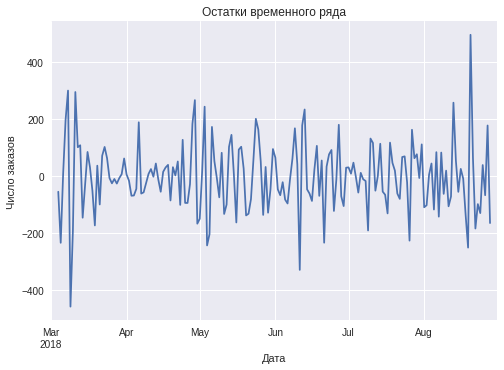

In [12]:
decomposed.resid.plot()
plt.title('Остатки временного ряда')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.show()

Периодичности и какой-либо систематики не наблюдается, поэтому можно сделать вывод о том, что ряд адекватен.

Рассмотрим график временного ряда и проверим его на стационарность:

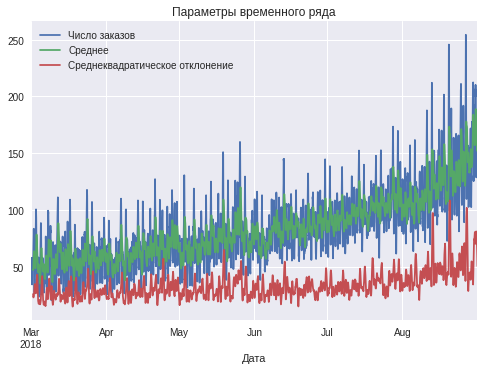

In [13]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.rolling(7).mean().plot()
plt.legend(['Число заказов','Среднее','Среднеквадратическое отклонение'])
plt.xlabel('Дата')
plt.title('Параметры временного ряда')
plt.show()

Видно, что среднее значение изменяется, поэтому можно судить о нестационарности ряда.

Также для проверки стационарности проведем **дополненный тест Дики-Фуллера**

**Нулевая гипотеза H0:** временной ряд может быть представлен единичным корнем, что он не является стационарным (имеет некоторую зависящую от времени структуру). 

**Альтернативная гипотеза H1:** временной ряд является стационарным.

Выберем p-значение в 1% для более точной проверки.

In [14]:
result = adfuller(data['num_orders'])
print(f'p-value: {result[1]}')
print('Нулевая гипотеза отклонена. Ряд стационарен' if result[1] < 0.01 else 'Нулевая гипотеза не отклонена. Ряд не стационарен')

p-value: 0.028940051402612906
Нулевая гипотеза не отклонена. Ряд не стационарен


И наглядно, и по тесту ряд не является стационарным, найдем его первые разности для того, чтобы привести к стационарному:

In [15]:
data.drop(['mean', 'std'], axis=1, inplace=True)

In [16]:
data_shift = data.shift()

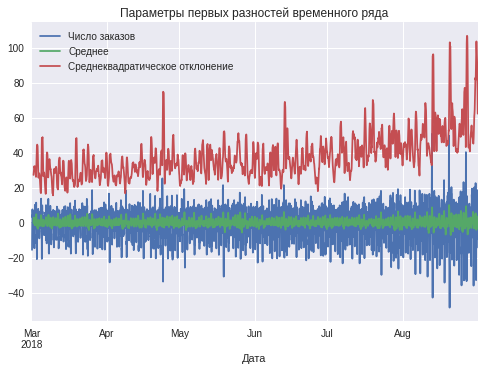

In [17]:
data -= data.shift()
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.rolling(7).mean().plot()
plt.legend(['Число заказов','Среднее','Среднеквадратическое отклонение'])
plt.xlabel('Дата')
plt.title('Параметры первых разностей временного ряда')
plt.show()

Удалим пропуски из ряда:

In [18]:
data.dropna(inplace=True)

Снова проведем **дополненный тест Дики-Фуллера**:

In [19]:
result = adfuller(data['num_orders'])
print(f'p-value: {result[1]}')
print('Нулевая гипотеза отергнута. Ряд стационарен' if result[1] < 0.01 else 'Нулева гипотеза не отклонена. Ряд не стационарен')

p-value: 1.0615658458313687e-28
Нулевая гипотеза отергнута. Ряд стационарен


Получившийся ряд стационарен.

In [20]:
data.drop(['mean', 'std'], axis=1, inplace=True)

Рассмотрим длительность временного ряда:

In [21]:
print(f'Начало временного ряда {data.index.min()}')
print(f'Конец временного ряда {data.index.max()}')

Начало временного ряда 2018-03-01 15:00:00
Конец временного ряда 2018-08-31 23:00:00


Длительность ряда - в течении 8-ми месяцев 2018 года.

## Обучение

Создадим несколько функций для упрощения кода:

Функция `make_features()` позволяет создать новые признаки для обучения модели: час, год, месяц, неделя, также разности временного ряда и скользящее среднее указанного на входе функции размера.

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    tmp = data.copy()
    tmp['hour'] = tmp.index.hour
    tmp['day'] = tmp.index.day
    tmp['day_of_week'] = tmp.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        tmp['lag_{}'.format(lag)] = tmp['num_orders'].shift(lag)
  
    tmp['rolling_mean'] = tmp['num_orders'].shift().rolling(rolling_mean_size).mean()
    return tmp

Функция `predictions()` для предсказаний двух моделей (пояснение далее)

In [23]:
def predictions(test_features, model_1, model_2):
    pred_1 = model_1.predict(test_features) + model_2.predict(test_features)
    return pred_1

Функция для вычисления RMSE:

In [24]:
def RMSE(target, prediction):
    return np.sqrt(mean_squared_error(target, prediction))

Добавим признаки во временной ряд для прогноза:

In [25]:
data_features = make_features(data, 24, 7)

Получили следующие признаки:

In [26]:
data_features.head()

,num_orders,hour,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 15:00:00,18.0,15,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 16:00:00,-23.0,16,1,3,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 17:00:00,1.0,17,1,3,-23.0,18.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 18:00:00,29.0,18,1,3,1.0,-23.0,18.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 19:00:00,-28.0,19,1,3,29.0,1.0,-23.0,18.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
data_features.dropna(inplace=True)

Разделим данные на тренировочную и тестовую выборки:

In [28]:
train, test = train_test_split(data_features, test_size=0.1, shuffle=False)

In [29]:
print('Размер тренировочной выборки : ', train.shape[0])
print('Размер тестовой выборки : ', test.shape[0])

Размер тренировочной выборки :  3939
Размер тестовой выборки :  438


Выделим целевые признаки из тренирвоочной и тестовой выборок:

In [30]:
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis = 1)

target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis = 1)

### Линейная регрессия и catboost

Для того, чтобы найти качественный прогноз мы воспользуемся предсказаниями двух моделей. Линейной регрессии - для выделения тренда, и градиентным бустингом catboost для предсказаний без учета общего тренда, вторая модель обучается на тестовых данных, из которых вычтены предсказания линейной регрессии.

Подберем гиперпараметры для модели catboost:

In [31]:
model_1 = LinearRegression()
model_1.fit(features_train, target_train)
pred_lin = model_1.predict(features_train)

In [32]:
rmse_cb = 1_000_000
depth_cb = 0
num_cb = 0

Здесь подбор гиперпараметров, он долгий, поэтому код я закомментила и ниже вывела экспериментально полученные параметры.

In [33]:
# for depth in range(9,13):
#     for num in range(1200, 2200, 200):
#         model_2 = CatBoostRegressor(
#                 random_state=12345, 
#                 learning_rate=0.1,
#                 boosting_type='Plain',
#                 max_depth=depth,
#                 n_estimators=num,
#                 num_leaves=31,
#                 verbose=False, 
#                 silent=None
#             )
#         model_2.fit(features_train, target_train - pred_lin)
#         predictions_ = predictions(features_test, model_1, model_2)
#         if RMSE(target_test, predictions_) < rmse_cb:
#             rmse_cb = RMSE(target_test, predictions_)
#             depth_cb = depth
#             num_cb = num

Получаем:

In [34]:
if num_cb == 0 and depth_cb == 0:
    num_cb = 2000
    depth_cb = 10

In [35]:
print(rmse_cb)
print('Параметры модели: ')
print(f'Глубина деревьев : {depth_cb}')
print(f'Кол-во деревьев : {num_cb}')

1000000
Параметры модели: 
Глубина деревьев : 10
Кол-во деревьев : 2000


Обучим модель с полученными гиперпараметрами:

In [36]:
model_2 = CatBoostRegressor(
            random_state=12345, 
            learning_rate=0.1,
            boosting_type='Plain',
            max_depth=depth_cb,
            n_estimators=num_cb,
            num_leaves=31,
            verbose=False, 
            silent=None
        )
model_2.fit(features_train, target_train - pred_lin)

### Случайный лес

Рассмотрим модель случайного леса и подберем гиперпараметры:

In [37]:
rmse_forest = 1_000_000
depth_forest = 0
num_forest = 0

Код также закоменчен в сиулу долгого выполнения.

In [38]:
# rmse_forest = 1_000_000
# for depth in range(5, 14):
#     for n_est in range(400, 100, 200):
#         model_forest = RandomForestRegressor(random_state=12345,
#                                             max_depth=depth,
#                                             n_estimators=n_est)
#         model_forest.fit(features_train, target_train)
#         pred_f = model_forest.predict(features_test)
#         if RMSE(target_test, pred_f) < rmse_forest:
#             rmse_forest = RMSE(target_test, pred_f)
#             depth_forest = depth
#             num_forest = n_est

In [39]:
if num_forest == 0 and depth_forest == 0:
    num_forest = 400
    depth_forest = 13

In [40]:
print(rmse_forest)
print('Поараметры модели:')
print(f'Глубина деревьев : {depth_forest}')
print(f'Кол-во деревьев : {num_forest}')

1000000
Поараметры модели:
Глубина деревьев : 13
Кол-во деревьев : 400


In [41]:
model_forest = RandomForestRegressor(random_state=12345,
                                            max_depth=depth_forest,
                                            n_estimators=num_forest)
model_forest.fit(features_train, target_train)

RandomForestRegressor(max_depth=13, n_estimators=400, random_state=12345)

## Тестирование

Константные предсказания для проверки адекватности модели:

In [42]:
pred_const = np.ones(test.shape[0]) * target_train.median()

In [43]:
predictions_test_cb = predictions(features_test, model_1, model_2)
predictions_test_forest = model_forest.predict(features_test)

print('RMSE константной модели :', RMSE(target_test, pred_const))
print('RMSE CatBoost : ', RMSE(target_test, predictions_test_cb))
print('RMSE RandomForest ', RMSE(target_test, predictions_test_forest))

RMSE константной модели : 59.00265066408566
RMSE CatBoost :  40.62124147881992
RMSE RandomForest  47.60923898651591


Модели адекватны. Получили RMSE меньше 48, а именно **40** у модели CatBoost, у случайного леса эта метрика выше, соответственно, модель работает хуже. Для построения прогноза выберем модель линейной регрессии и градиентного бустинга catboost.

Создадим датафрейм с предсказаниями и соответствующими датами:

In [44]:
pred = pd.DataFrame(predictions_test_cb, index=test.index)

Построим прогноз.

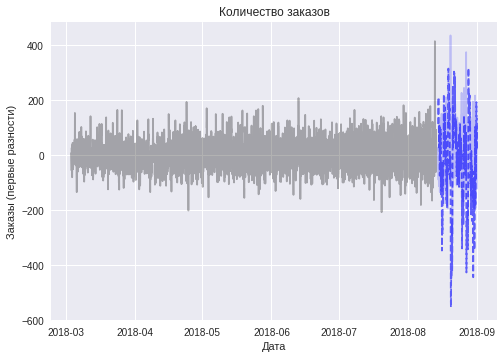

In [45]:
fig, ax = plt.subplots()

ax.plot(target_train.rolling(20).sum(), 'k', alpha=0.3)
ax.plot(target_test.rolling(20).sum(), 'b', alpha=0.2)
ax.plot(pred.rolling(20).sum(), 'b--', alpha=0.6)


plt.title('Количество заказов')
plt.xlabel('Дата')
plt.ylabel('Заказы (первые разности)')
plt.show()

Таким образом, мы получили значение RMSE модели равное **40**, изначальный ряд не был стационарен, поэтому вычислением первых разностей ряда мы добились его стационарности. 

Использовались модели линейной регрессии и градиентного бустинга CatBoost.